# AirBnB - A Sentiment Analysis

# Introduction

## What is AirBnB?
AirBnB are ....

## What Information Do We Have?
The data ..



In [1]:
%%javascript
function toggler(){
    if(window.already_toggling){
        // Don't add multiple buttons.
        return 0
    }
    let btn = $('.input').append('<button>Toggle Code</button>')
        .children('button');
    btn.on('click', function(e){
        let tgt = e.currentTarget;
        $(tgt).parent().children('.inner_cell').toggle()
    })
    window.already_toggling = true;
}
// Since javascript cells are executed as soon as we load
// the notebook (if it's trusted), and this cell might be at the
// top of the notebook (so is executed first), we need to
// allow time for all of the other code cells to load before
// running. Let's give it 5 seconds.

setTimeout(toggler, 30000);    

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML, Markdown, Javascript

# paths
## 1. Code
myCodePath = "helper_files"
## 2. Data
myDataPath = "data"
import sys
sys.path.append(myCodePath)

from formattingWidth import formatting_width, hideCode, myHTML, myHTMLreplace
from pandasExt import *

formatting_width()

if False:
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()" id="topdiv"><input type="submit" value="Click here: Toggle on/off code."></form>''')



In [3]:
import os
import glob
import numpy as np
import pandas as pd
# turn off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# show full column text
pd.set_option('display.max_colwidth', None)
# extend output
pd.set_option('display.max_rows', 100000)

from time import time
               
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
from pprint import pprint
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import fasttext

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Calculate Sentimants?
## The lists of sentiments are saved as pickle files
## To redo this analysis, set these to True
sentiments=False
sentiments_eng=False

In [4]:
display(myHTML(f"Rows and columns in: calendar calendar.shape, listings listings.shape, reviews reviews.shape"))

None

In [5]:
import calendar as cal
# calendar variable orders
day_order = [day for day in cal.day_name]
month_order = [mon for mon in cal.month_name][1:]

In [6]:
# location of all data files
all_files = glob.glob(os.path.join(myDataPath , "*.csv") )

# load all datafiles as dataframes, save as a dictionary
dfs = {f.split("/")[-1].replace(".csv",""): pd.read_csv(f, low_memory=False) for f in all_files if "csv" in f}

In [7]:
dfs.keys()

dict_keys(['seattle_reviews', 'boston_calendar', 'boston_listings', 'boston_reviews', 'seattle_calendar', 'seattle_listings'])

In [8]:
# add city key to each dataframe
for key in dfs.keys():
    if "boston" in key:
        dfs[key]['city'] = "Boston"
    else:
        dfs[key]['city'] = "Seattle"

In [9]:
# concatenate the relevant datafiles
calendar = pd.concat([dfs[key] for key in dfs.keys() if 'calendar' in key]).reset_index(drop=True)        
listings = pd.concat([dfs[key] for key in dfs.keys() if 'listings' in key]).reset_index(drop=True)          
reviews = pd.concat([dfs[key] for key in dfs.keys() if 'reviews' in key]).reset_index(drop=True) 

In [73]:
myHTML(f"Rows and columns in: calendar {calendar.shape}, listings {listings.shape}, reviews {reviews.shape}")

myHTML(f"Unique listing ids in listings {len(listings.id.unique())}")

myHTML(f"\nColumns in:<br>calendar: {', '.join([str(x).title() for x in calendar.columns])},<br><br> listings: {', '.join([str(x).title() for x in listings.columns])},<br><br> reviews: {', '.join([str(x).title() for x in reviews.columns])}")

In [11]:
myHTML(f"The listings id variable is a unique identifier (number of entries for each id: {listings.id.value_counts().unique()}")

In [12]:
listings.review_scores_rating.mean()

93.31600201918224

In [13]:
describe = listings.review_scores_rating.myDescribe()


In [14]:
def myBins(describe):
    intervals = describe.index[~describe.index.isin(['count', 'mean', 'std', 'min','max'])]
    bins = [describe.loc[intervals[ind]] for ind in range(len(intervals)) if  describe.loc[intervals[ind]] != describe.loc[intervals[ind-1]]]
    return bins


listings.groupby('city').review_scores_rating.mean()

city
Boston    91.92
Seattle   94.54
Name: review_scores_rating, dtype: float64

In [15]:
listings.groupby('city').review_scores_accuracy.mean()

city
Boston    9.43
Seattle   9.64
Name: review_scores_accuracy, dtype: float64

In [16]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                7403 non-null   int64  
 1   listing_url                       7403 non-null   object 
 2   scrape_id                         7403 non-null   int64  
 3   last_scraped                      7403 non-null   object 
 4   name                              7403 non-null   object 
 5   summary                           7083 non-null   object 
 6   space                             5777 non-null   object 
 7   description                       7403 non-null   object 
 8   experiences_offered               7403 non-null   object 
 9   neighborhood_overview             4956 non-null   object 
 10  notes                             3822 non-null   object 
 11  transit                           5179 non-null   object 
 12  access

#### Is there information in the calendar or reviews data files that would be useful?

In [17]:
calendar.sample(5)

listing_id        date available    price     city
1049290    13266133  2017-08-13         t   $85.00   Boston
744841     13081090  2016-12-05         t  $309.00   Boston
1486424     6968101  2016-05-27         f      NaN  Seattle
1958599     8373832  2016-01-13         t  $450.00  Seattle
590848      8134231  2017-08-10         f      NaN   Boston

In [18]:
reviews.sample(5)

listing_id        id        date  reviewer_id reviewer_name  \
8786       4008373  42266588  2015-08-12     32656773         Bader   
140520     6089865  87134442  2016-07-18      3648979          John   
21207      1000883   7259368  2013-09-13      8440305         Julie   
41383      2614387  44121982  2015-08-24     35921357       Shannon   
136388     2183058  37827433  2015-07-11     17976469      Kristina   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comments  \
8786                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            very good location    
140520                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Terrific location in the north end, literally steps from the Old North Church.  The apartment was clean but perhaps a little shabby.  This may be more due to the age of the building than anything else.  The location made up for any deficiencies however.     
21207                                                   

In [19]:
import os
import pickle
class SentimentsWordCloud(object):
    '''extractEnglish() = extract only english entries
       extractStrings() = transform the column of string to a single string - calls extractEnglish is required
       extractSentiments() = extracts words with positive, neutral or negative sentiments
       wordCloudViz() = create a word cloud visualization from sentiments (positive and negative only)
    '''
    def __init__(self,df,dfCol,groupby=False,english=False,englishPercent=50,stopwords = [],update=False,proportional=False):
        '''
        Required inputs: df= relevant dataframe
                         reviewCol = A column (of strings) of a dataframe
        Optional inputs: groupby = a category to groupby
                         english = whether or not to extract english strings only
                         englishPercent = if english strings, probability of match
                         stopwords = a list of word to omit from the word cloud
        '''
        self.df = df
        self.dfCol = dfCol
        self.groupby = groupby
        self.english = english
        self.englishPercent = englishPercent
        self.stopwords = stopwords
        self.pickleFile = False
        self.update = update
        self.proportional=proportional
        # get current working directory file list
        self.file_list = os.listdir(os.getcwd())
        # if the file (using the standard naming convention) is in cwd
        # load it, and use it instead of recreating the sentitments dictionaries
        # unless update is specified
        if f"sentiments_{self.groupby}_{self.english}.pickle" in self.file_list and not self.update:
            self.pickleFile = True
            with open(f"sentiments_{self.groupby}_{self.english}.pickle", 'rb') as handle:
                self.sentiments = pickle.load(handle)
        else:
            # only load the fasttext model if no pickle file is available
            # AND english only text is required.
            if self.english:
                # initialize fasttext model
                self.ft = fasttext.load_model('lid.176.bin')

        
    def extractEnglish(self,text):
        '''
        Use fasttext to extract only english strings
            with percentage accuracy self.englishPercent
            - creates a boolean for each row
        '''
        # check for NaN
        if not isinstance(text,str):
            return False
        """Return a boolean if text is predicted (over perc% to be english)"""
        result = self.ft.predict(text.replace("\n"," ").lower(),k=1)
        if result[1][0] > self.englishPercent/100 and result[0][0] == '__label__en':
            return True
        else:
            return False
        
    def extractEnglishStrings(self):
        '''
         # if English only statements are required, filter the dataframe
        '''
        # if the file (using the standard naming convention) is in cwd
        # load it, and use it instead of recreating the sentitments dictionaries
        # unless update is specified
        if "sentiments_is_English_rows.pickle" in self.file_list and not self.update:
            with open("sentiments_is_English_rows.pickle", 'rb') as handle:
                is_eng = pickle.load(handle)
        else:
            # apply extractEnglish to each row
            is_eng = self.df[self.dfCol].apply(self.extractEnglish)
        # filter the dataframe
        self.df = self.df.loc[is_eng]
        # this part takes a while, so I am going to pickle the boolean series
        # of whether a row is predicted to be in english
        with open(f"sentiments_is_English_rows.pickle", 'wb') as handle:
            pickle.dump(is_eng, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return is_eng
        
    def extractStrings(self):
        '''
        extract string(s) from the dataframe column
        One string if not grouping
        One string per group if grouping
        '''
        # if English only statements are required, filter the dataframe
        if self.english:
            self.extractEnglishStrings()
        if self.groupby:
            self.commentsString = self.df.dropna(subset=[self.dfCol]).groupby(self.groupby)[self.dfCol].apply(" ".join)
        else:
            self.commentsString = pd.Series(" ".join(self.df.dropna(subset=[self.dfCol])[self.dfCol]))
            self.commentsString.index = ["All"]
        return self.commentsString
            
    def extractSentiments(self):
        if self.pickleFile:
            return self.sentiments
        # extract the strings required
        self.extractStrings()
        # import required modules
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        
        # create a dictionary to capture the sentiments for each group
        self.sentiments ={}
                                 
        for indx in range(self.commentsString.shape[0]):
            commentString = self.commentsString.iloc[indx]
            # create a list from the string
            words_list=commentString.split()

            # create an instance of the analyzer
            sid = SentimentIntensityAnalyzer()
            # lists to store the sentiments
            pos_word_list=[]
            neu_word_list=[]
            neg_word_list=[]

            # dictionary container for the lists
            sentiments = {}

            # loop through the lists of words
            for word in words_list:
                if (sid.polarity_scores(word)['compound']) >= 0.5:
                    pos_word_list.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -0.5:
                    neg_word_list.append(word)
                else:
                    neu_word_list.append(word)                

            sentiments['Positive'] = pos_word_list        
            sentiments['Neutral'] = neu_word_list    
            sentiments['Negative'] = neg_word_list
            
            self.sentiments[self.commentsString.index[indx]] = sentiments
            
        # this part takes a while, so I am going to pickle the results of each run
        # then use those files to avoid having to run 
        pickle_filename = f"sentiments_{self.groupby}_{self.english}.pickle"
        with open(pickle_filename, 'wb') as handle:
            pickle.dump(self.sentiments, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        return self.sentiments
    
    
    def wordCloudViz(self):
        # generate sentiments
        sentiments_dict = self.extractSentiments()
        for item in self.stopwords:
            STOPWORDS.add(item)
        
        for key in sentiments_dict:
            sentiments_all = sentiments_dict[key]
            # ensure that there are words for the word cloud
            # if not, move on to the next key
            if 0 in [len(sentiments_all[k]) for k in sentiments_all.keys()]:
                continue
            
            # If the area of plots is set to be proportional (using a layout N x N, with plots (N-1)*(N-1) and 1*1
            # for example if the ratio is 100:1, N**2 -2N -99
            # then an adjustment to the width of the wordCloud has to be made (i.e. the number of columns the plot
            # occupies)
            c = int(len(sentiments_all["Positive"])/len(sentiments_all["Negative"])) -1
            import math
            # number of columns that generates proportional subplots
            ncols = int(2+math.sqrt((1**2) - (4*(-2*c)))/(2*1))
            if self.proportional:
                wcWidth = int(1050*((ncols-1)/ncols))
            else:
                wcWidth=1050

            wordCloud = {}
            for label, value in {'Positive':['salmon','Pastel1'],"Negative":['grey',"Dark2"]}.items():
                wordCloud[label] = WordCloud(width = 1600, height = wcWidth,
                                      random_state=1,
                                      background_color=value[0], colormap=value[1],
                                      collocations=False, stopwords = STOPWORDS).generate(" ".join(sentiments_all[label]))
            if not self.proportional:
                # Set figure size
                fig, ax = plt.subplots(1,2, figsize=(14.69, 8.27))
                for ind, label in enumerate(wordCloud):
                    # Display image
                    ax[ind].imshow(wordCloud[label]) 
                    # No axis details
                    ax[ind].axis("off");
                    ax[ind].set_title(f"{label} sentiments for {key} reviews".title(), fontsize=14, weight="bold")
                plt.tight_layout()
                plt.show()
            else:
                # set area of plots to be proportional (using a layout N x N, with plots (N-1)*(N-1) and 1*1
                # for example if the ratio is 100:1, N**2 -2N -99
                c = int(len(sentiments_all["Positive"])/len(sentiments_all["Negative"])) -1
                
                import math
                ncols = int(2+math.sqrt((1**2) - (4*(-2*c)))/(2*1))
                nrows=ncols
                fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=[14.7,8.27])
                # get gridspec, upper left plot
                gs = axs[0, 0].get_gridspec()
                # remove all axis
                for ax in axs.flatten():
                    ax.axis("off")
                # remove the underlying axes
                for ax in axs[0:ncols-1].flatten():
                    ax.remove()
                # larger plot
                axbig = fig.add_subplot(gs[0:, 0:ncols-1])
                # smaller plot
                axsmall=axs[nrows-1][ncols-1]
                axbig.axis("off")
                fig.tight_layout()
                for ind, label in enumerate(wordCloud):
                    if label == "Positive":
                        axbig.imshow(wordCloud[label]) 
                    else:
                        axsmall.imshow(wordCloud[label]) 
                fig.suptitle(f"Sentiments for {key} reviews\n(ratio of {c+1}:1)".title(), fontsize=14, weight="bold", y=1.05)
                fig.show()
            yield
    
  

In [20]:
myHTML(f"To create all of the required pickle files took {round(1835.3076219558716,2)} seconds, or {round(1835.3076219558716/60,2)} minutes")

In [21]:
import math
c = 99
int(2+math.sqrt((1**2) - (4*(-2*c)))/(2*1))

16

In [22]:
recreate_pickle_files = False
if recreate_pickle_files:
    # start timer
    t0=time()
    options = [False, 'city', 'listing_id']
    for option in options:
        for value in [True, False]:
            swc = SentimentsWordCloud(reviews,'comments',groupby=option,english=value,update=True)
            swc.extractSentiments()
    print(f'Time Taken: {time()-t0}')

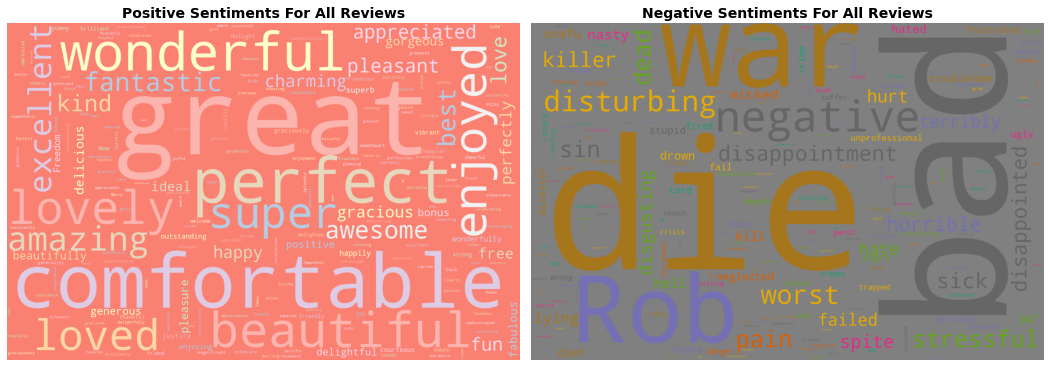

In [23]:
swc = SentimentsWordCloud(reviews,'comments')
vizGen = swc.wordCloudViz()
next(vizGen)

In [24]:
file_list = os.listdir(os.getcwd())
if "sentiments_is_English_rows.pickle" in file_list:
    with open("sentiments_is_English_rows.pickle", 'rb') as handle:
        is_eng = pickle.load(handle)

eng_comments = reviews.loc[is_eng,'comments']
nonEng_comments = reviews.loc[~is_eng,'comments']
nonEng_comments.dropna().loc[nonEng_comments.dropna().str.lower().str.contains('die')].iloc[0]
for line in nonEng_comments.dropna().loc[nonEng_comments.dropna().str.lower().str.contains(' die')]:
    myHTMLreplace(line, word=' die')
    break

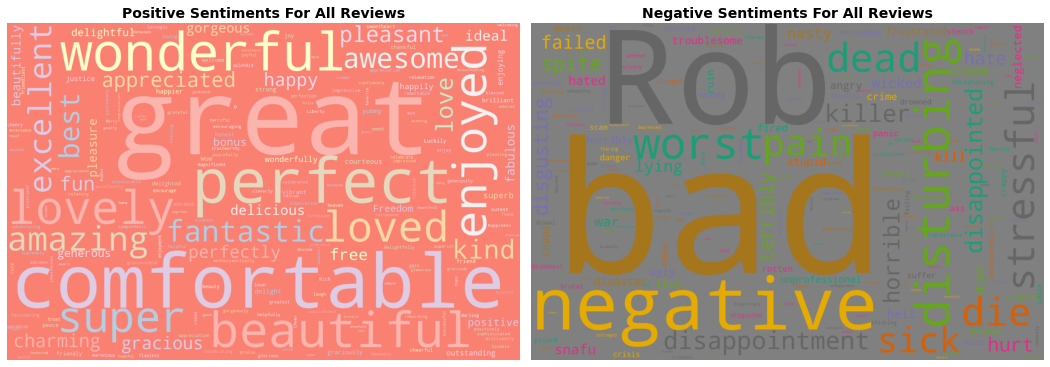

In [25]:
swc = SentimentsWordCloud(reviews,'comments',english=True)
vizGen = swc.wordCloudViz()
next(vizGen)

In [26]:
for line in eng_comments.dropna().loc[eng_comments.dropna().str.lower().str.contains(' die')]:
    myHTMLreplace(line, word=' die')
    break

In [27]:
for line in eng_comments.dropna().loc[eng_comments.dropna().str.lower().str.contains(' rob')]:
    myHTMLreplace(line, word=' Rob')
    break


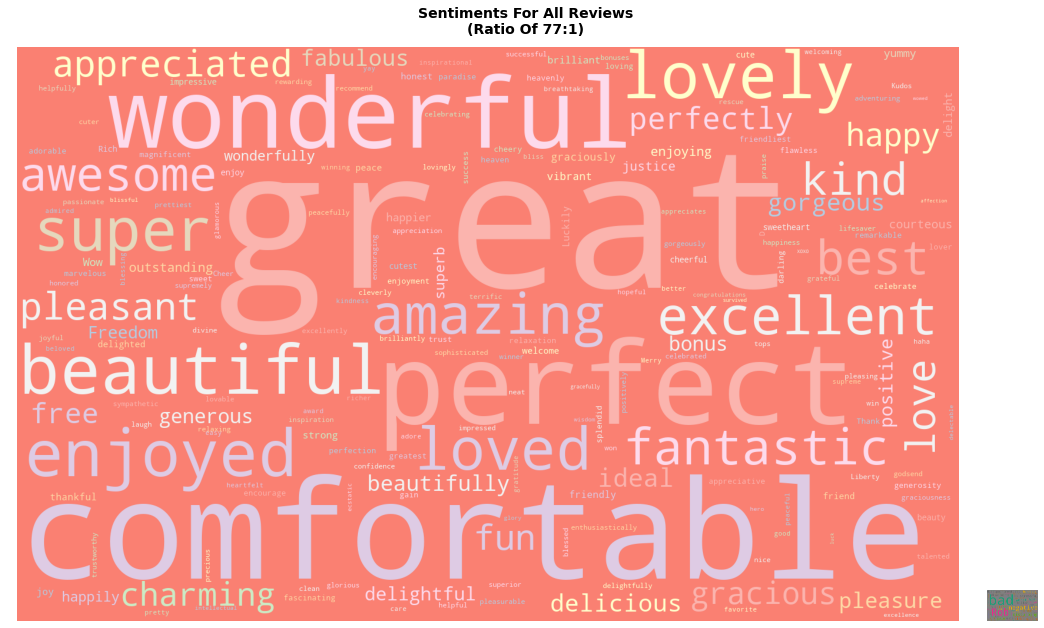

In [28]:
swc = SentimentsWordCloud(reviews,'comments',english=True,proportional=True)
vizGen = swc.wordCloudViz()
next(vizGen)

In [29]:
aspect = 14.7/8.27
aspect

1.777509068923821

In [30]:
sent = swc.extractSentiments()

In [31]:

def proportionalPlot(ncols,nrows):
    df = pd.DataFrame(np.random.randn(10, 3), columns=['A', 'B', 'C'])

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=[14.7,8.27])
    # get gridspec, upper left plot
    gs = axs[0, 0].get_gridspec()
    # remove all axis
    for ax in axs.flatten():
        ax.axis("off")
    # remove the underlying axes
    for ax in axs[0:ncols-1].flatten():
        ax.remove()
    axbig = fig.add_subplot(gs[0:, 0:ncols-1])
    df.plot.bar(ax=axbig)
    axbig.axis("off")
    axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
                   xycoords='axes fraction', va='center')
    df.plot.kde(ax=axs[nrows-1][ncols-1]);

    fig.tight_layout()

In [32]:
english_rows = swc.extractEnglishStrings()

In [70]:
English = reviews[english_rows].dropna(subset=["comments"])

searchDF = English
searchCol= 'comments'
searchWord = 'dead'

def highlightWord(searchDF,searchCol,searchWord,include):
    i=0
    for row in searchDF[searchDF[searchCol].str.lower().str.contains(f"{searchWord} ",regex=True)].comments:
        myHTML(f"\n{searchCol} number {i}".title())
        sentences = [f"{sentence}." for sentence in row.split('.') if f'{searchWord} ' in sentence]
        for statement in sentences:
            myHTMLreplace(statement.lower(),word=f'{searchWord} ')
        i+=1
        if i == include:
            break
highlightWord(searchDF,searchCol,searchWord,10)    

In [34]:
# highlightWord(nonEnglish,searchCol,'die')    

#### Time Taken
        Grouped by city, english language only: Time Taken: 303.38720989227295 seconds
                            loaded from pickle: Time Taken: 15.748566150665283 seconds

In [35]:
# display(myHTML(f"For all reviews: The number of negative words {len(sentiments_all['Negative'])}; The number of positive words {len(sentiments_all['Positive'])}"))

In [36]:
def sentimentCount(allComments, cityComments):
    # number of positive/negative words
    len_all_pos = len(allComments['Positive'])
    len_all_neg = len(allComments['Negative'])
    len_bos_pos = len(cityComments["Boston"]['Positive'])
    len_bos_neg = len(cityComments["Boston"]['Negative'])
    len_sea_pos = len(cityComments["Seattle"]['Positive'])
    len_sea_neg = len(cityComments["Seattle"]['Negative'])
    top_all_neg = pd.Series(allComments['Negative']).value_counts().index[:10]
    top_bos_neg = pd.Series(cityComments["Boston"]['Negative']).value_counts().index[:10]
    top_sea_neg = pd.Series(cityComments["Seattle"]['Negative']).value_counts().index[:10]
    display(myHTML(f'''For all reviews: The number of negative words {len_all_neg}; The number of positive words {len_all_pos};
    For a proportion of positive of {round(len_all_pos/(len_all_pos+len_all_neg),2)}.<br>The top 10 negative words are: {", ".join(top_all_neg)}'''.title()))
    display(myHTML(f'''For boston reviews: The number of negative words {len_bos_neg}; The number of positive words {len_bos_pos};
    For a proportion of positive of {round(len_bos_pos/(len_bos_pos+len_bos_neg),2)}.<br>The top 10 negative words are: {", ".join(top_bos_neg)}'''.title()))
    display(myHTML(f'''For seattle reviews: The number of negative words {len_sea_neg}; The number of positive words {len_sea_pos};
    For a proportion of positive of {round(len_sea_pos/(len_sea_pos+len_sea_neg),2)}.<br>The top 10 negative words are: {", ".join(top_sea_neg)}'''.title()))

In [37]:
# sentimentCount(sentiments_all, city_sentiment)

In [38]:
# sentimentCount(sentiments_all_eng, city_sentiment_eng)

In [39]:
display(myHTML("<h2>Decision About Merging</h2)"))

None

In [40]:
# If dataframes are to be merged:
## currently, no
if False:
    # merge listing with calendar
    df = listings.merge(calendar, left_on='id', right_on='listing_id')
    # merge result with reviews
    df = df.merge(reviews, left_on='id', right_on='listing_id')

In [41]:
# Function: create date variables
def dateVariables(df,dateVar):
    df[dateVar] = pd.to_datetime(df[dateVar])
    df['year'] = df[dateVar].dt.year
    df['month'] = df[dateVar].dt.strftime("%B")
    df['month'] = pd.Categorical(df['month'],
                                      categories = month_order,
                                      ordered=True)
    df['day'] = df[dateVar].dt.strftime("%A")
    df['day'] = pd.Categorical(df['day'],
                                      categories = day_order,
                                      ordered=True)

# create date variables
dateVariables(calendar,'date')
dateVariables(reviews,'date')
dateVariables(listings,'last_scraped')


# reencode available to booleen
calendar['available'] = calendar['available'].replace({"t":True,"f":False})
# reencode price to float
calendar["price"] = calendar.price.str.replace("$","").str.replace(",","").astype(float)

In [42]:
# extract the dataframes for the latest dates
recent_calendar = calendar.loc[calendar.groupby('listing_id').date.idxmax()].reset_index(drop=True)
recent_reviews = reviews.loc[reviews.groupby('listing_id').date.idxmax()].reset_index(drop=True)

#### Do the dataframes include the same listings?

In [43]:
[x for x in recent_calendar.listing_id.values if x not in listings.id.values]

[]

In [44]:
[x for x in listings.id.values if x not in recent_calendar.listing_id.values]

[]

In [45]:
[x for x in recent_reviews.listing_id.values if x not in listings.id.values]

[]

In [46]:
missing_reviews = [x for x in listings.id.values if x not in recent_reviews.listing_id.values]

display(HTML(f'''There are {len(missing_reviews)} listings that are not included in the reviews dataframe. That is {round(100*len(missing_reviews)/len(listings),2)}%.
This matches the missing reviews from the listings dataframe (i.e. where Number of Listings is zero): {len(listings.loc[listings.number_of_reviews == 0])}'''))

All listings, in the listings data, are in the calendar data file. But close to 19% are missing from the reviews data.

In [47]:
[x for x in listings.columns if 'review' in x.lower()]

['number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [48]:
len(listings.loc[listings.number_of_reviews == 0])

1383

In [49]:
def groupbyPerc(df,var1,var2):
    '''
    groupbyPerc: group dataframe df by var1 and var2
                 unstack var2
                 get percentages for each category in var2 (for each in var1)
                 generate horizontal bar plot
    '''
    (df.groupby([var1,var2])
       .size()
       .unstack(var2)
       .apply(lambda x: x*100/x.sum(), axis=1)
       .plot.barh(width=0.9))
    plt.title(f"Percentage {var2} by {var1}".title(), fontsize=14, weight="bold")
    plt.ylabel(f"{var1}".title())
    plt.xlabel("Percentage".title())
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           title=f"{var2}".title(), title_fontsize = 12);

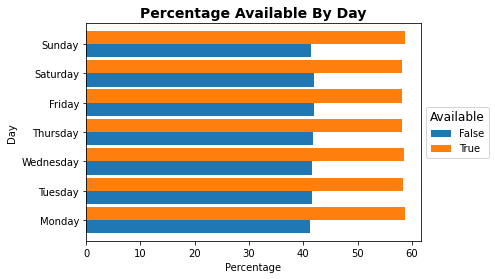

In [50]:
groupbyPerc(calendar,"day","available")

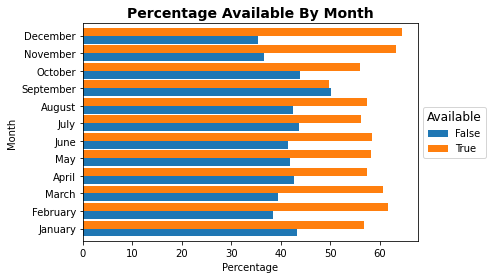

In [51]:
groupbyPerc(calendar,"month","available")

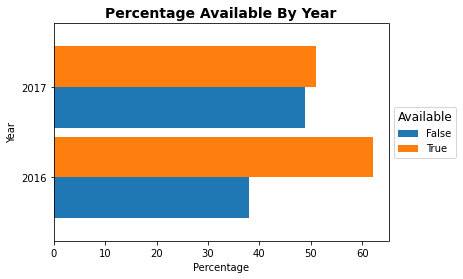

In [52]:
groupbyPerc(calendar,"year","available")

              city_merge
              Boston    127.976
              Seattle   173.926
              Name: price, dtype: float64

In [53]:
calendar.describe().T

count       mean        std     min        25%        50%  \
listing_id 2702460.00 6950804.94 4052439.85 3335.00 3865312.75 7035369.00   
price      1577579.00     162.60     143.70   10.00      79.00     120.00   
year       2702460.00    2016.33       0.47 2016.00    2016.00    2016.00   

                  75%         max  
listing_id 9504211.25 14933461.00  
price          200.00     7163.00  
year          2017.00     2017.00

In [54]:
listings.describe().T

count              mean          std  \
id                             7403.00        6950001.48   4052396.78   
scrape_id                      7403.00 20160492479532.68 400929617.51   
host_id                        7403.00       20210534.87  19623093.35   
host_listings_count            7401.00             32.22       123.59   
host_total_listings_count      7401.00             32.22       123.59   
latitude                       7403.00             45.07         2.64   
longitude                      7403.00            -97.52        25.61   
accommodates                   7403.00              3.20         1.89   
bathrooms                      7373.00              1.24         0.55   
bedrooms                       7387.00              1.28         0.82   
beds                           7393.00              1.67         1.08   
square_feet                     153.00            856.03       647.19   
guests_included                7403.00              1.56         1.20   
minimum_nights                 7403.00              2.76        13.24   
maximum_nights                 7403.00          14313.37   1162232.13   
availability_30                7403.00             12.85        12.07   
availability_60                7403.00             29.56        23.84   
availability_90                7403.00             48.63        35.01   
availability_365               7403.00            213.09       138.34   
number_of_reviews              7403.00             20.68        36.73   
review_scores_rating           5943.00             93.32         8.21   
review_scores_accuracy         5922.00              9.54         0.82   
review_scores_cleanliness      5932.00              9.42         1.00   
review_scores_checkin          5925.00              9.72         0.68   
review_scores_communication    5934.00              9.73         0.66   
review_scores_location         5926.00              9.52         0.78   
review_scores_value            5926.00              9.32         0.89   
license                           0.00               NaN          NaN   
calculated_host_listings_count 7403.00              7.69        21.47   
reviews_per_month              6020.00              2.03         1.97   
year                           7403.00           2016.00         0.00   

                                             min               25%  \
id                                       3335.00        3864099.50   
scrape_id                      20160104002432.00 20160104002432.00   
host_id                                  4193.00        4343163.50   
host_listings_count                         0.00              1.00   
host_total_listings_count                   0.00              1.00   
latitude                                   42.24             42.35   
longitude                                -122.42           -122.33   
accommodates                                1.00              2.00   
bathrooms                                   0.00              1.00   
bedrooms                                    0.00              1.00   
beds                                        0.00              1.00   
square_feet                                 0.00            420.00   
guests_included                             0.00              1.00   
minimum_nights                              1.00              1.00   
maximum_nights                              1.00             95.50   
availability_30                             0.00              0.00   
availability_60                             0.00              1.00   
availability_90                             0.00              7.00   
availability_365                            0.00             77.00   
number_of_reviews                           0.00              1.00   
review_scores_rating                       20.00             91.00   
review_scores_accuracy                      2.00              9.00   
review_scores_cleanliness                   2.00              9.00   
review_scores_ch

In [55]:
reviews.describe().T

count        mean         std     min         25%         50%  \
listing_id  153124.00  3787517.47  3248161.22 3353.00  1071843.00  3139972.00   
id          153124.00 40342403.39 24778966.56 1021.00 20620259.75 38463998.00   
reviewer_id 153124.00 21922545.05 18816034.68   15.00  6342335.75 17552614.00   
year        153124.00     2014.72        1.06 2009.00     2014.00     2015.00   

                    75%         max  
listing_id   5958674.00 14843783.00  
id          53978187.50 99990454.00  
reviewer_id 32977175.50 93350341.00  
year            2015.00     2016.00

In [56]:
listings.head(1).T

0
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                12147973
listing_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          https://www.airbnb.com/rooms/12147973
scrape_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   20160906204935
last_scraped                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [57]:
# # create a float from price data
# if isinstance(listings["price"][0],str):
#     listings["price"]=listings.price.str.extract(r'(\d+\.\d+)').astype(float)

# nlistings = listings.join(listings.groupby("zipcode").id.transform('size'),rsuffix="_d")
# nlistings = nlistings.rename({"id_d":"zip_count"},axis=1)
# zipOne = nlistings.groupby("zipcode").first().reset_index()
# zipOne['zip_count'] = zipOne.zip_count.astype(int)

In [58]:

def avgBy(df,var,varname,groupby='zipcode'):
    '''
    avgBy - groupby by, get average of var, join on original dataframe
            extract one complete row of the dataframe for each group
    '''
    if isinstance(df[var][0],str):
        df[var]=df[var].str.extract(r'(\d+\.\d+)').astype(float)
    df = df.dropna(subset=[var])
    plistings = df.join(df.groupby(groupby)[var].transform('mean'),rsuffix="_d")
    plistings = plistings.rename({f"{var}_d":varname},axis=1)
    pOne = plistings.groupby(groupby).first().reset_index()
    pOne[varname] = pOne[varname].apply(lambda x: np.sqrt(x)*10).astype(int)
    return pOne


In [59]:
def countBy(df,var,varname,groupby='zipcode'):
    '''
    avgBy - groupby by, get average of var, join on original dataframe
            extract one complete row of the dataframe for each group
    '''
    if isinstance(df[var][0],str):
        df[var]= df[var].str.extract(r'(\d+\.\d+)').astype(float)
    df = df.dropna(subset=[var])
    plistings = df.join(df.groupby(groupby)[var].transform('size'),rsuffix="_d")
    plistings = plistings.rename({f"{var}_d":varname},axis=1)
    pOne = plistings.groupby(groupby).first().reset_index()
    pOne[varname] = pOne[varname].apply(lambda x: np.sqrt(x)*10).astype(int)
    return pOne


In [60]:
avgRatings = avgBy(listings,'review_scores_rating','Average Ratings',groupby='zipcode')
avgPrice = avgBy(listings,'price','Average Price',groupby='zipcode')
countZip = countBy(listings,'id','Count',groupby='zipcode')

In [61]:
# get the coordinates of a bounding box
def coords(grp):
    return (grp.longitude.min(), grp.longitude.max(),      
            grp.latitude.min(),  grp.latitude.max())


In [62]:
def mapRegions(df, s=10, labels=False, annot=""):
    '''
    mapRegions - plots a map of Boston and Seattle, with observations for lat/lon
                 which depend on dataframe used
    inputs -     df - a dataframe contain lat lon information (optional information about a third variable)
                 s - size of points. Either fixed, or depending on a third variable
    '''
    # to overwrite s type check later
    switch=False
    if not isinstance(s,int):
        switch=True
    # load maps
    boston_map = plt.imread('boston_map.png')
    seattle_map = plt.imread('seattle_map.png')
    # dataframes 
    dfB = df[df.city=="Boston"]
    dfS = df[df.city=="Seattle"]
    
    def coords(grp):
        return (grp.longitude.min(), grp.longitude.max(),      
                grp.latitude.min(),  grp.latitude.max())

    BBox = listings.groupby('city').apply(coords)

    # create fig with subplots
    fig, ax = plt.subplots(1,2, figsize = (24,10))
            
    # create bounding box
    def coords(grp):
        return (grp.longitude.min(), grp.longitude.max(),      
                grp.latitude.min(),  grp.latitude.max())

    BBox = listings.groupby('city').apply(coords)
    
    # unique cities
    cities = df.city.unique()
    # loop over cities
    for i, city in enumerate(cities):
        # Map
        mapC = plt.imread(f'{city.lower()}_map.png')
        # Bounding box
        BBoxC = BBox.loc[city]
        # city dataframe
        dfC = df.loc[df.city==city]
        
        # check if the size is a fixed number or variable
        if switch:
            sC = dfC[s]
            sT=s
            # 5th percentile
            sc5 = dfC[s].quantile(0.05)
        else:
            sC=s
            sT="Spatial Location"
            sc5 = False
            

        # plot points, with size relative to the value of the s variable
        ax[i].scatter(dfC.longitude, dfC.latitude, zorder=1, alpha= 0.6, c='b', s=sC)
        if labels:
            for ind in range(dfC.shape[0]):
                # set text color
                if sc5 and dfC.iloc[ind][s] < sc5:
                    tColor='red'
                else:
                    tColor='black'
    #             print(dfB['longitude'][ind],dfB['latitude'][ind])
                # Overall averages
                ax[i].annotate(f"{annot}{dfC.iloc[ind][s]}",
                            (dfC.iloc[ind]['longitude'],dfC.iloc[ind]['latitude']),
                            size=12, ha='right',
                            va='bottom', weight = "normal",
                            color = tColor,
    #                             xytext=(1, 1), textcoords='axes fraction',
                            bbox=dict(facecolor = "white", edgecolor="grey", boxstyle='round,pad=0.05')
                            )

        ax[i].set_title(f'Plotting  {sT}  Data on {city} Map')
        ax[i].set_xlim(BBoxC[0],BBoxC[1])
        ax[i].set_ylim(BBoxC[2],BBoxC[3])
        ax[i].imshow(mapC, zorder=0, extent = BBoxC, aspect= 'auto');


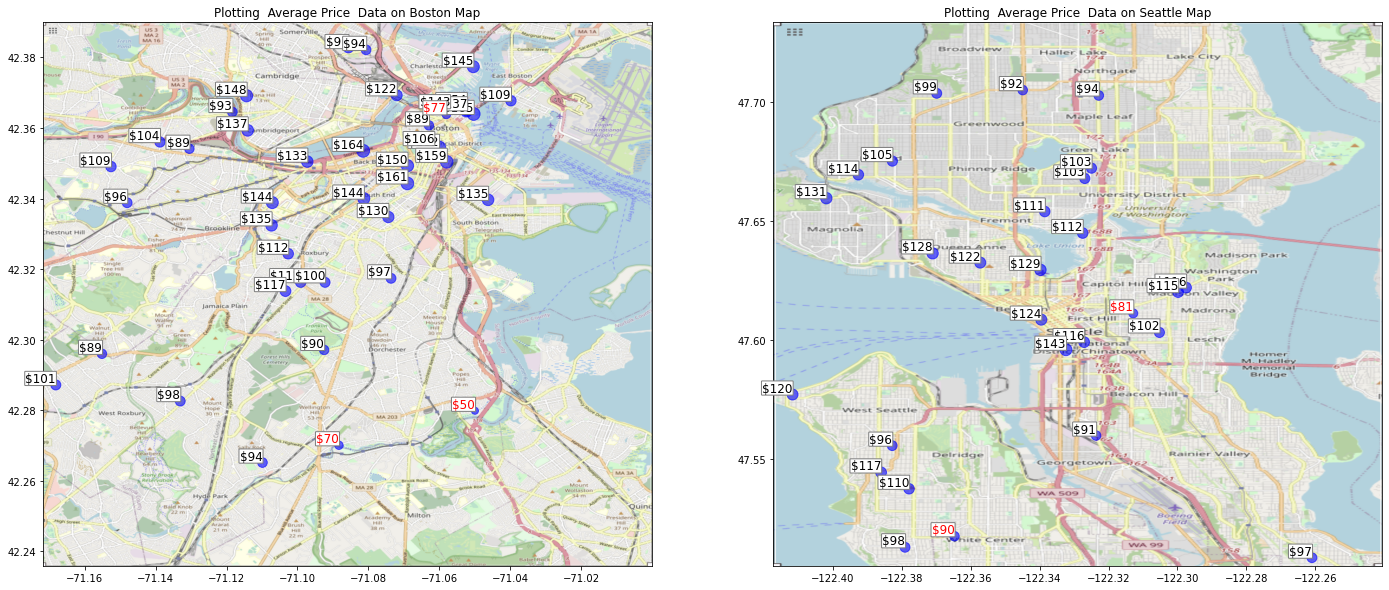

In [63]:
mapRegions(avgPrice,s='Average Price',labels=True, annot="$")

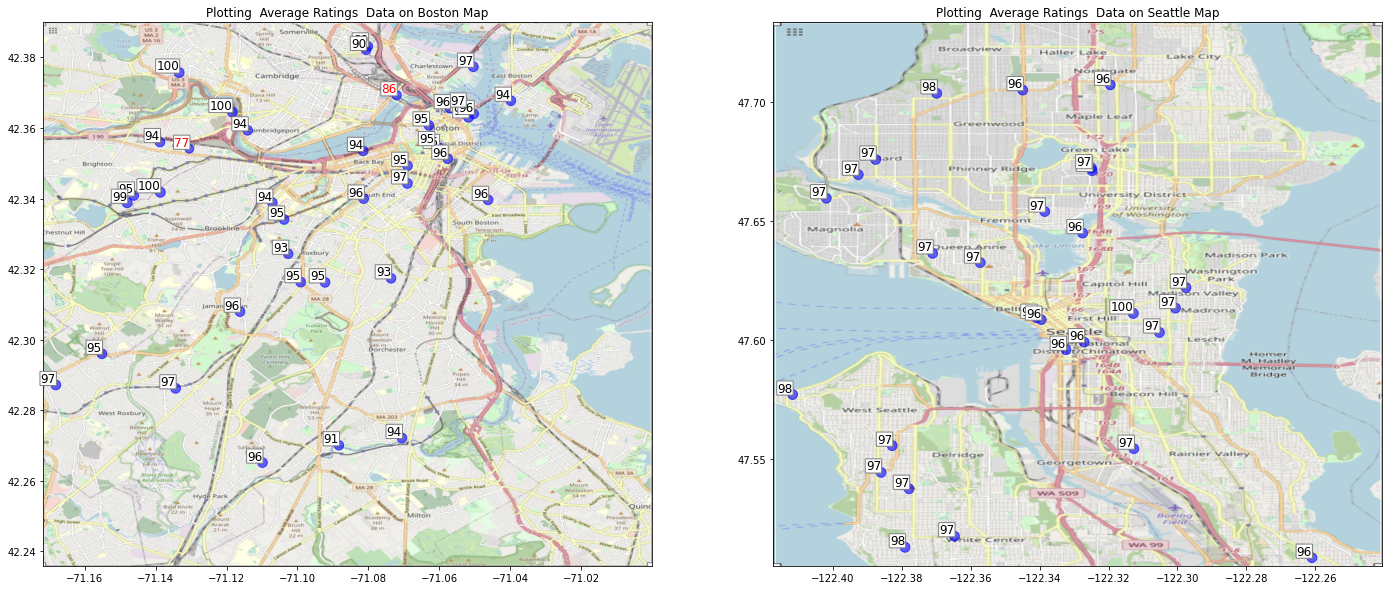

In [64]:
mapRegions(avgRatings,s='Average Ratings',labels=True, annot="")

In [65]:
2**16

65536

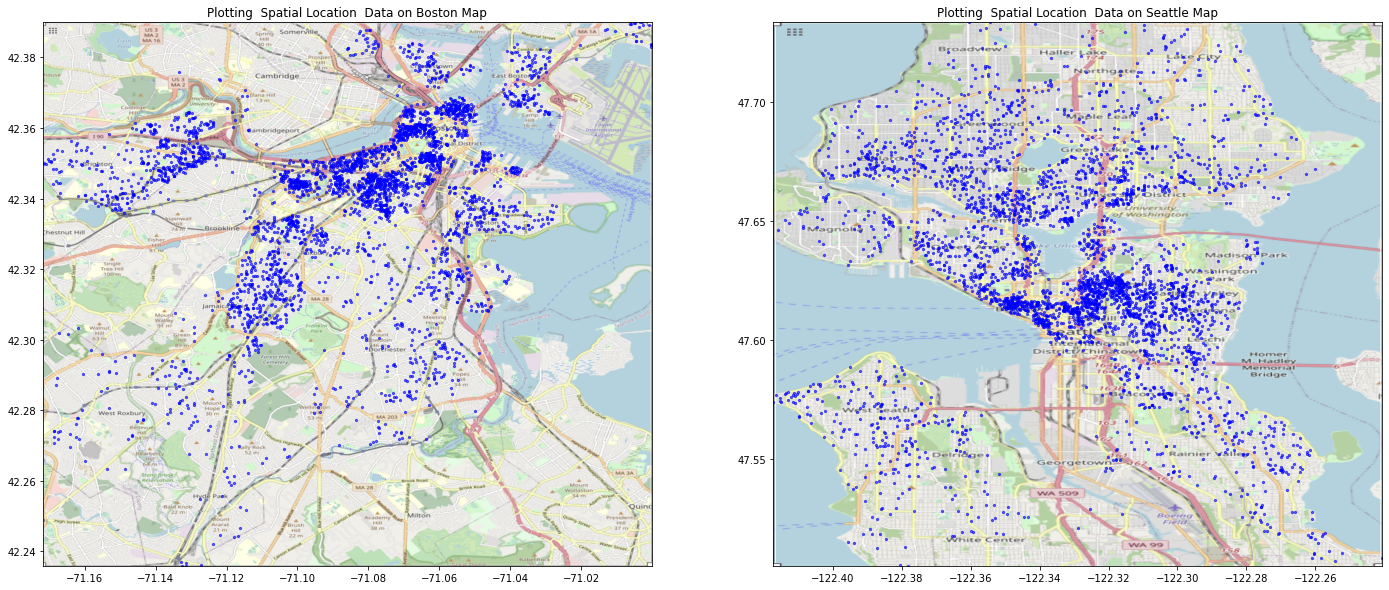

In [66]:
mapRegions(listings, s=5)

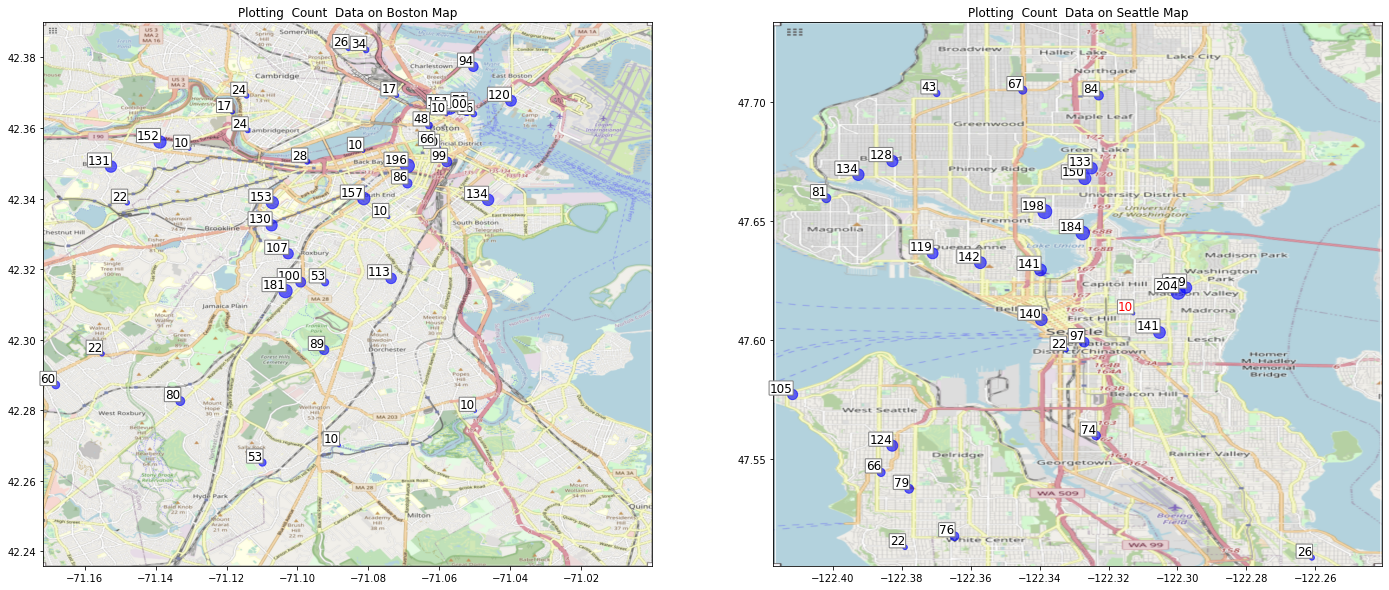

In [67]:
mapRegions(countZip,s='Count', labels=True)

## Let's Remove Non-English Reviews

In [ ]:
"ELOISA".title()

In [69]:
!jupyter nbconvert p1_blog_airBnB.ipynb --to html  --no-input --no-prompt 

[NbConvertApp] Converting notebook p1_blog_airBnB.ipynb to html
[NbConvertApp] Writing 8200363 bytes to p1_blog_airBnB.html
